# RLC Circuit Analysis

This notebook demonstrates RLC circuit analysis with Pulsim, including validation against analytical solutions.

## Contents
1. RC Circuit (First-Order)
2. RL Circuit (First-Order)
3. RLC Circuit (Second-Order)
4. Analytical Solution Validation

In [1]:
import pulsim as ps
import numpy as np
import matplotlib.pyplot as plt

## 1. RC Circuit (First-Order)

Step response of RC low-pass filter:
$$v_{out}(t) = V_s \cdot (1 - e^{-t/\tau})$$

where $\tau = RC$

In [2]:
# RC circuit parameters
R = 1000      # 1kΩ
C = 1e-6      # 1µF
V_source = 1.0
tau_rc = R * C

print(f"RC Circuit Parameters:")
print(f"  R = {R} Ω")
print(f"  C = {C*1e6} µF")
print(f"  τ = RC = {tau_rc*1000} ms")

# Build circuit
ckt_rc = ps.Circuit()
gnd = ckt_rc.ground()
n_in = ckt_rc.add_node("v_in")
n_out = ckt_rc.add_node("v_out")

ckt_rc.add_voltage_source("Vin", n_in, gnd, V_source)
ckt_rc.add_resistor("R1", n_in, n_out, R)
ckt_rc.add_capacitor("C1", n_out, gnd, C)

# Simulate step response
x0 = np.zeros(ckt_rc.system_size())
x0[0] = V_source  # V_in
x0[1] = 0.0       # V_out (capacitor discharged)

t_stop = 5 * tau_rc
dt = tau_rc / 100

times, states, success, msg = ps.run_transient(ckt_rc, 0.0, t_stop, dt, x0)
print(f"\nSimulation: {success}")

RC Circuit Parameters:
  R = 1000 Ω
  C = 1.0 µF
  τ = RC = 1.0 ms

Simulation: True


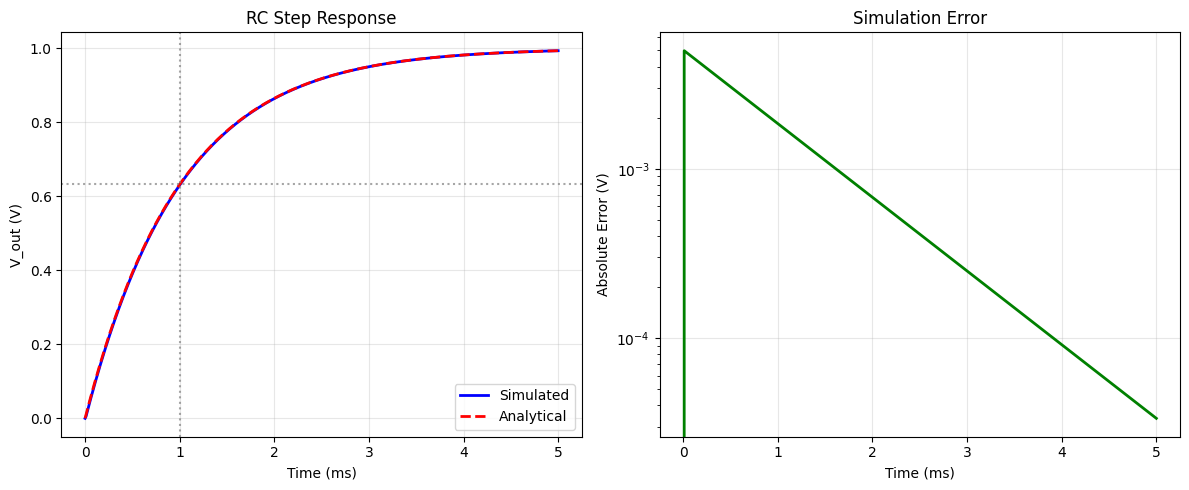

Maximum error: 4.98e-03 V
RMS error: 1.58e-03 V


In [3]:
# Compare with analytical solution
times = np.array(times)
v_out_sim = np.array([s[1] for s in states])

# Analytical: Pulsim provides RCAnalytical
rc_analytical = ps.RCAnalytical(R, C, V_initial=0.0, V_final=V_source)
v_out_theory = np.array([rc_analytical.voltage(t) for t in times])

# Plot comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(times*1000, v_out_sim, 'b-', linewidth=2, label='Simulated')
plt.plot(times*1000, v_out_theory, 'r--', linewidth=2, label='Analytical')
plt.axhline(y=0.632*V_source, color='gray', linestyle=':', alpha=0.7)
plt.axvline(x=tau_rc*1000, color='gray', linestyle=':', alpha=0.7)
plt.xlabel('Time (ms)')
plt.ylabel('V_out (V)')
plt.title('RC Step Response')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
error = np.abs(v_out_sim - v_out_theory)
plt.semilogy(times*1000, error, 'g-', linewidth=2)
plt.xlabel('Time (ms)')
plt.ylabel('Absolute Error (V)')
plt.title('Simulation Error')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Maximum error: {np.max(error):.2e} V")
print(f"RMS error: {np.sqrt(np.mean(error**2)):.2e} V")

## 2. RL Circuit (First-Order)

Step response of RL circuit:
$$i(t) = \frac{V_s}{R} \cdot (1 - e^{-t/\tau})$$

where $\tau = L/R$

In [4]:
# RL circuit parameters
R_rl = 100    # 100Ω
L = 10e-3     # 10mH
V_rl = 5.0
tau_rl = L / R_rl

print(f"RL Circuit Parameters:")
print(f"  R = {R_rl} Ω")
print(f"  L = {L*1000} mH")
print(f"  τ = L/R = {tau_rl*1000} ms")

# Build circuit
ckt_rl = ps.Circuit()
gnd = ckt_rl.ground()
n_in = ckt_rl.add_node("v_in")
n_mid = ckt_rl.add_node("v_mid")

ckt_rl.add_voltage_source("Vin", n_in, gnd, V_rl)
ckt_rl.add_resistor("R1", n_in, n_mid, R_rl)
ckt_rl.add_inductor("L1", n_mid, gnd, L)

# Simulate
x0_rl = np.zeros(ckt_rl.system_size())
x0_rl[0] = V_rl

t_stop_rl = 5 * tau_rl
dt_rl = tau_rl / 100

times_rl, states_rl, success_rl, msg_rl = ps.run_transient(ckt_rl, 0.0, t_stop_rl, dt_rl, x0_rl)
print(f"\nSimulation: {success_rl}")

RL Circuit Parameters:
  R = 100 Ω
  L = 10.0 mH
  τ = L/R = 0.1 ms

Simulation: True


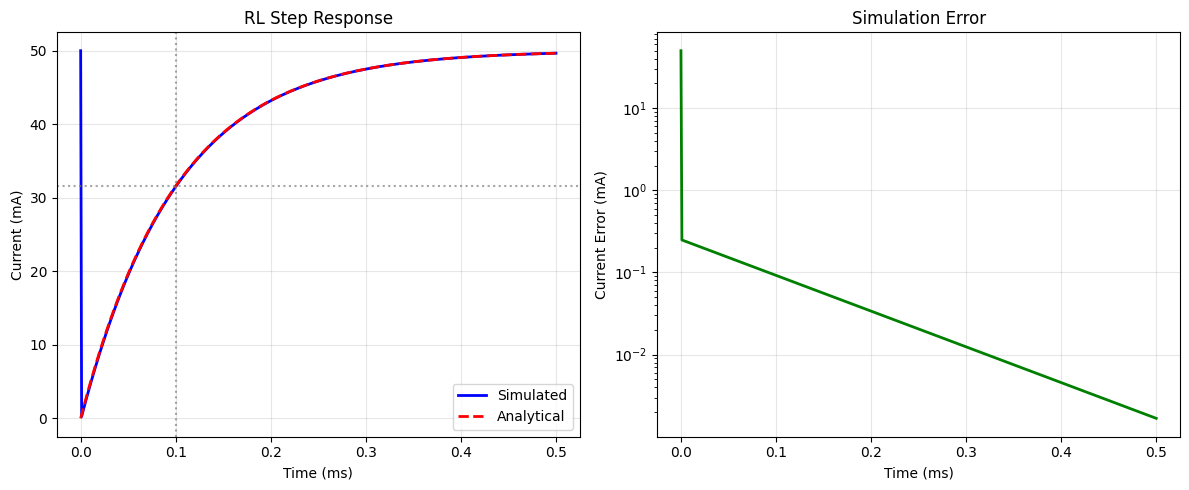

Maximum current error: 50.0000 mA


In [5]:
# Compare with analytical solution
times_rl = np.array(times_rl)
v_mid_sim = np.array([s[1] for s in states_rl])

# Use RLAnalytical
rl_analytical = ps.RLAnalytical(R_rl, L, V_rl, I_initial=0.0)
i_theory = np.array([rl_analytical.current(t) for t in times_rl])

# Current through inductor = (Vin - Vmid) / R
i_sim = (V_rl - v_mid_sim) / R_rl

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(times_rl*1000, i_sim*1000, 'b-', linewidth=2, label='Simulated')
plt.plot(times_rl*1000, i_theory*1000, 'r--', linewidth=2, label='Analytical')
plt.axhline(y=V_rl/R_rl*0.632*1000, color='gray', linestyle=':', alpha=0.7)
plt.axvline(x=tau_rl*1000, color='gray', linestyle=':', alpha=0.7)
plt.xlabel('Time (ms)')
plt.ylabel('Current (mA)')
plt.title('RL Step Response')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
error_rl = np.abs(i_sim - i_theory)
plt.semilogy(times_rl*1000, error_rl*1000, 'g-', linewidth=2)
plt.xlabel('Time (ms)')
plt.ylabel('Current Error (mA)')
plt.title('Simulation Error')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Maximum current error: {np.max(error_rl)*1000:.4f} mA")

## 3. RLC Circuit (Second-Order)

The RLC series circuit has three response types:

- **Underdamped** ($\zeta < 1$): Oscillatory response
- **Critically damped** ($\zeta = 1$): Fastest non-oscillatory response
- **Overdamped** ($\zeta > 1$): Slow exponential decay

$$\zeta = \frac{R}{2} \sqrt{\frac{C}{L}}$$
$$\omega_0 = \frac{1}{\sqrt{LC}}$$

In [6]:
def build_rlc_circuit(R, L, C, V_source):
    """Build RLC series circuit."""
    ckt = ps.Circuit()
    gnd = ckt.ground()
    
    n_in = ckt.add_node("v_in")
    n_r = ckt.add_node("v_r")
    n_out = ckt.add_node("v_out")
    
    ckt.add_voltage_source("Vin", n_in, gnd, V_source)
    ckt.add_resistor("R1", n_in, n_r, R)
    ckt.add_inductor("L1", n_r, n_out, L)
    ckt.add_capacitor("C1", n_out, gnd, C)
    
    return ckt

def simulate_rlc(R, L, C, V_source, t_stop, dt):
    """Simulate RLC circuit and return results."""
    ckt = build_rlc_circuit(R, L, C, V_source)
    
    x0 = np.zeros(ckt.system_size())
    x0[0] = V_source
    
    times, states, success, msg = ps.run_transient(ckt, 0.0, t_stop, dt, x0)
    
    if success:
        v_out = np.array([s[2] for s in states])
        return np.array(times), v_out
    return None, None

# RLC parameters
L_rlc = 1e-3    # 1mH
C_rlc = 1e-6    # 1µF
V_rlc = 1.0

omega_0 = 1 / np.sqrt(L_rlc * C_rlc)
f_0 = omega_0 / (2 * np.pi)

print(f"RLC Circuit:")
print(f"  L = {L_rlc*1000} mH")
print(f"  C = {C_rlc*1e6} µF")
print(f"  ω₀ = {omega_0:.1f} rad/s")
print(f"  f₀ = {f_0:.1f} Hz")
print(f"\nCritical resistance: R_crit = 2√(L/C) = {2*np.sqrt(L_rlc/C_rlc):.1f} Ω")

RLC Circuit:
  L = 1.0 mH
  C = 1.0 µF
  ω₀ = 31622.8 rad/s
  f₀ = 5032.9 Hz

Critical resistance: R_crit = 2√(L/C) = 63.2 Ω


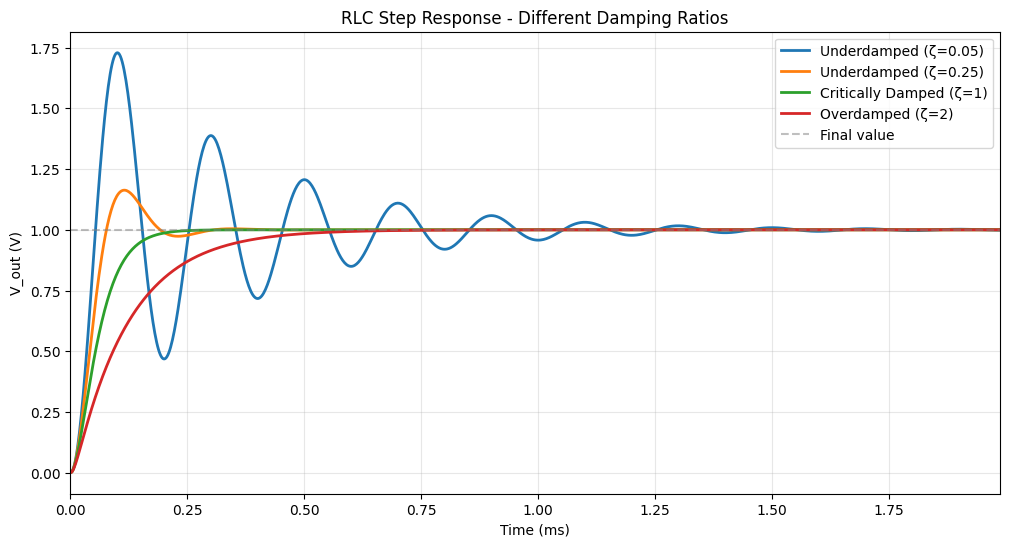

In [7]:
# Compare underdamped, critically damped, and overdamped
R_crit = 2 * np.sqrt(L_rlc / C_rlc)

cases = [
    (R_crit * 0.1, 'Underdamped (ζ=0.05)'),
    (R_crit * 0.5, 'Underdamped (ζ=0.25)'),
    (R_crit * 1.0, 'Critically Damped (ζ=1)'),
    (R_crit * 2.0, 'Overdamped (ζ=2)'),
]

t_stop_rlc = 10 / f_0
dt_rlc = 1 / (100 * f_0)

plt.figure(figsize=(12, 6))

for R, label in cases:
    times, v_out = simulate_rlc(R, L_rlc, C_rlc, V_rlc, t_stop_rlc, dt_rlc)
    if times is not None:
        zeta = R / (2 * np.sqrt(L_rlc / C_rlc))
        plt.plot(times*1000, v_out, linewidth=2, label=f'{label}')

plt.axhline(y=V_rlc, color='gray', linestyle='--', alpha=0.5, label='Final value')
plt.xlabel('Time (ms)')
plt.ylabel('V_out (V)')
plt.title('RLC Step Response - Different Damping Ratios')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim([0, t_stop_rlc*1000])
plt.show()

## 4. Validation with RLCAnalytical

Pulsim provides `RLCAnalytical` for exact analytical solutions.

RLCAnalytical:
  Damping ratio ζ = 0.200
  Natural frequency ω₀ = 31622.8 rad/s
  Damping coefficient α = 6324.6
  Damping type: RLCDamping.Underdamped


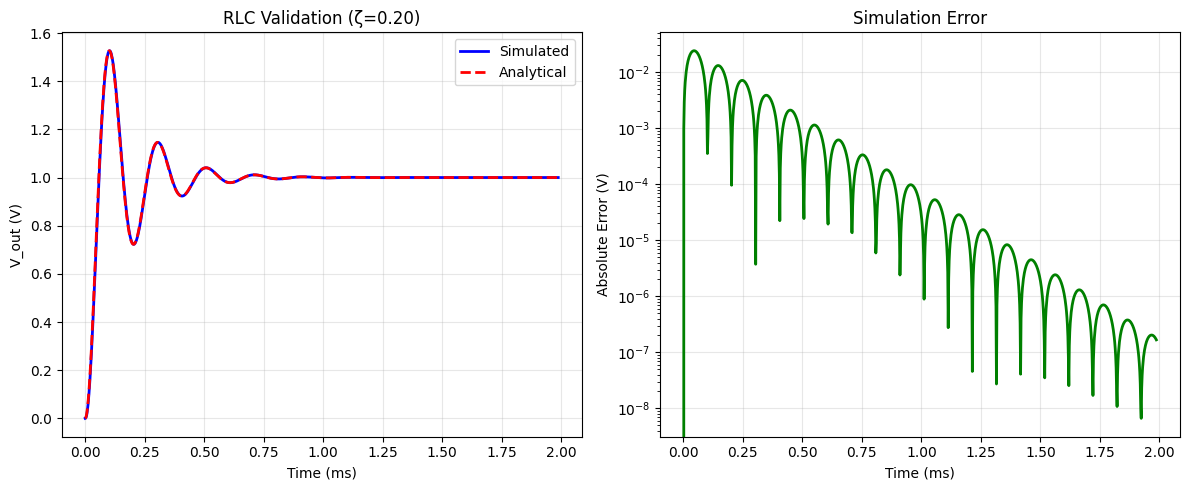


Validation Results:
  Maximum error: 2.41e-02 V
  RMS error: 4.55e-03 V


In [8]:
# Use RLCAnalytical for validation
R_test = R_crit * 0.2  # Underdamped case
rlc_analytical = ps.RLCAnalytical(R_test, L_rlc, C_rlc, V_rlc,V_initial=0.0, I_initial=0.0)

# Get damping info
print(f"RLCAnalytical:")
print(f"  Damping ratio ζ = {rlc_analytical.zeta():.3f}")
print(f"  Natural frequency ω₀ = {rlc_analytical.omega_0():.1f} rad/s")
print(f"  Damping coefficient α = {rlc_analytical.alpha():.1f}")
print(f"  Damping type: {rlc_analytical.damping_type()}")

# Simulate
times_val, v_out_sim = simulate_rlc(R_test, L_rlc, C_rlc, V_rlc, t_stop_rlc, dt_rlc)

# Analytical solution
v_out_analytical = np.array([rlc_analytical.voltage(t) for t in times_val])

# Plot comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(times_val*1000, v_out_sim, 'b-', linewidth=2, label='Simulated')
plt.plot(times_val*1000, v_out_analytical, 'r--', linewidth=2, label='Analytical')
plt.xlabel('Time (ms)')
plt.ylabel('V_out (V)')
plt.title(f'RLC Validation (ζ={rlc_analytical.zeta():.2f})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
error_val = np.abs(v_out_sim - v_out_analytical)
plt.semilogy(times_val*1000, error_val, 'g-', linewidth=2)
plt.xlabel('Time (ms)')
plt.ylabel('Absolute Error (V)')
plt.title('Simulation Error')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nValidation Results:")
print(f"  Maximum error: {np.max(error_val):.2e} V")
print(f"  RMS error: {np.sqrt(np.mean(error_val**2)):.2e} V")

## Summary

### Circuit Types

| Circuit | Time Constant | Response Type |
|---------|---------------|---------------|
| RC | τ = RC | First-order exponential |
| RL | τ = L/R | First-order exponential |
| RLC | Depends on ζ | Second-order (damped oscillation) |

### Analytical Solution Classes

```python
# RC circuit
rc = ps.RCAnalytical(R, C, V_initial=0.0, V_final=V_source)
v = rc.voltage(t)  # Capacitor voltage at time t

# RL circuit
rl = ps.RLAnalytical(R, L, V_source, I_initial=0.0)
i = rl.current(t)  # Inductor current at time t

# RLC circuit
rlc = ps.RLCAnalytical(R, L, C, V_source, V_initial=0.0, I_initial=0.0)
v = rlc.voltage(t)    # Capacitor voltage
zeta = rlc.zeta()     # Damping ratio
w0 = rlc.omega_0()    # Natural frequency
alpha = rlc.alpha()   # Damping coefficient
dtype = rlc.damping_type()  # RLCDamping enum
```

**Next:** [Convergence Analysis](07_convergence.ipynb)